In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
from datetime import datetime as dt
import pandas_market_calendars as mcal
import dateutil

In [2]:
# get range of dates from the last 100 days
import datetime
numdays = 100
# get current date
base = datetime.datetime.today()
# list comp for current date - number of days for range of dates
date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]
# put into dataframe to do datetime formatting
dates = pd.DataFrame(date_list, columns = ['dates'])
dates['dates'] = pd.to_datetime(dates.dates)
dates['dates'] = dates['dates'].dt.strftime('%Y-%m-%d')
# sort dates ascending values
dates = dates.sort_values(by="dates", ascending=True)
# all dates are in a list to use in REST API to fetch data
dates = list(dates['dates'])

In [3]:
ticker = 'X:DOGEUSD'
range_agg = '/range/1/minute/'
unadjusted = 'unadjusted=true'
sort = '&sort=asc'
limit = '&limit=50000'
POLYGON_URL = 'https://api.polygon.io/v2/aggs/ticker/'
#from_date = '2021-05-18'
#to_date = '2021-06-18'
POLYGON_API = '&apiKey=x6XqEaDjOWJXwVQRyBQ5kMEi8KlCYZqo'

In [4]:
datetime = []
open_price = []
high_price = []
low_price = []
close_price = []
volume = []
for date in dates:
    polygon = POLYGON_URL + ticker + range_agg + date + '/' + date + '?' + unadjusted + sort + limit + POLYGON_API
    r_polygon = requests.get(polygon)
    polygon_response = r_polygon.json()
    for aggs in range(len(polygon_response['results'])):
        datetime.append(dt.fromtimestamp(polygon_response['results'][aggs]['t']/ 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
        open_price.append(polygon_response['results'][aggs]['o'])
        high_price.append(polygon_response['results'][aggs]['h'])
        low_price.append(polygon_response['results'][aggs]['l'])
        close_price.append(polygon_response['results'][aggs]['c'])
        volume.append(polygon_response['results'][aggs]['v'])

In [5]:
df = pd.DataFrame(list(zip(datetime,open_price,high_price,low_price, close_price,volume)),
columns =['datetime', 'open', 'high', 'low', 'close', 'volume'])

In [6]:
df.head()

,datetime,open,high,low,close,volume
0,2021-03-12 00:00:00,0.056076,0.056076,0.056065,0.056065,5089.910000
1,2021-03-12 00:01:00,0.055936,0.056025,0.055933,0.055933,9922.519128
2,2021-03-12 00:02:00,0.056096,0.056146,0.056016,0.056089,116720.013144
3,2021-03-12 00:03:00,0.056114,0.056146,0.056099,0.056146,39100.893907
4,2021-03-12 00:04:00,0.056141,0.056146,0.056141,0.056146,82686.569105


In [7]:
len(df)

141938

In [8]:
df['datetime']

0         2021-03-12 00:00:00
1         2021-03-12 00:01:00
2         2021-03-12 00:02:00
3         2021-03-12 00:03:00
4         2021-03-12 00:04:00
                 ...         
141933    2021-06-19 23:54:00
141934    2021-06-19 23:55:00
141935    2021-06-19 23:56:00
141936    2021-06-19 23:57:00
141937    2021-06-19 23:58:00
Name: datetime, Length: 141938, dtype: object

In [9]:
df.describe()

,open,high,low,close,volume
count,141938.000000,141938.000000,141938.000000,141938.000000,1.419380e+05
mean,0.232331,0.268428,0.181039,0.231251,4.390977e+05
std,0.158948,0.171385,0.109381,0.158382,1.001172e+06
min,0.049663,0.049750,0.049646,0.049646,5.737000e-05
25%,0.060662,0.060765,0.060584,0.060661,3.065561e+04
50%,0.231921,0.309243,0.186290,0.229884,1.075693e+05
75%,0.331200,0.371542,0.266194,0.330107,3.633847e+05
max,0.737845,0.740000,0.731514,0.737768,2.312773e+07


In [10]:
# Select only the important features i.e. the date and price
data = df[["datetime","close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
data = data.rename(columns = {"datetime":"ds","close":"y"}) #renaming the columns of the dataset
data.tail(5)

,ds,y
141933,2021-06-19 23:54:00,0.2876
141934,2021-06-19 23:55:00,0.2870
141935,2021-06-19 23:56:00,0.2866
141936,2021-06-19 23:57:00,0.2869
141937,2021-06-19 23:58:00,0.2869


In [11]:
from prophet import Prophet
m = Prophet(changepoint_prior_scale=0.01) # the Prophet class (model)
m.fit(data) # fit the model using all data

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


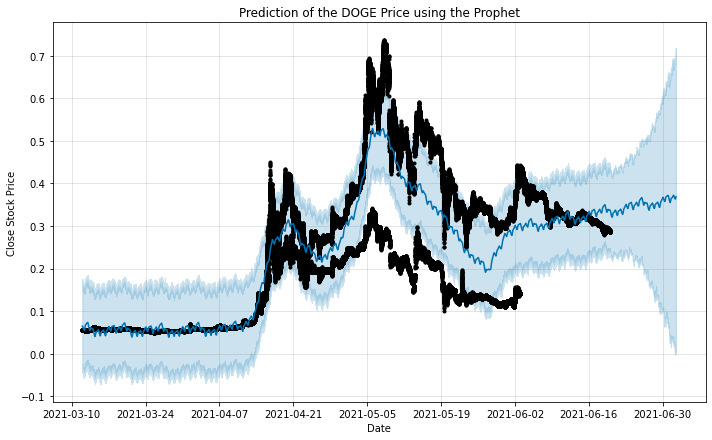

In [12]:
future = m.make_future_dataframe(periods=300, freq='H') #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the DOGE Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

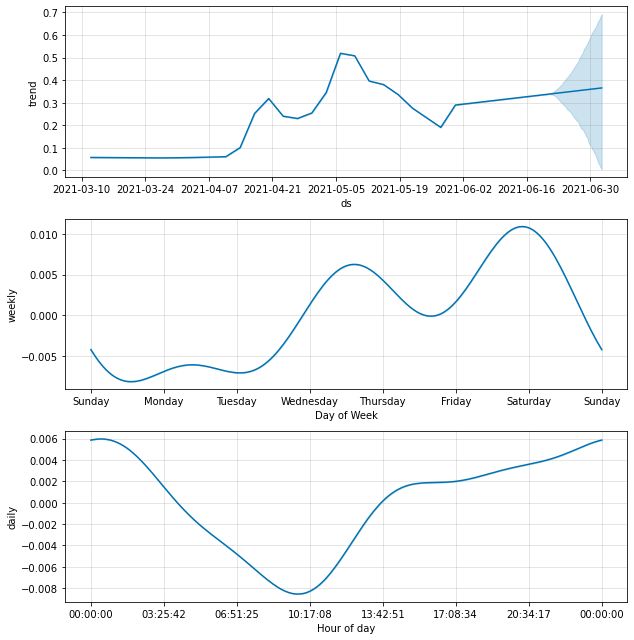

In [13]:
m.plot_components(prediction)
plt.show()

In [ ]:
# try with some hyperparameter tuning
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 minutes', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Making 8926 forecasts with cutoffs between 2021-03-19 00:13:00 and 2021-06-19 23:28:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd7401f2610>
